In [3]:
# import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from scripts import download, assets

In [ ]:
# Yahoo financial
download.updateShortPeriodData()

In [6]:
# Yahoo financial
download.download30mdata('ZM')

[*********************100%***********************]  1 of 1 completed
Saved ZM 30 minute interval data.


In [2]:
# Yahoo financial
data = yf.download('TSLA', start='2023-02-09', end='2023-03-09', interval='5m')
data = pd.DataFrame(data)

[*********************100%***********************]  1 of 1 completed


In [2]:
tsla = assets.Equity('TSLA', threshold=0.02, duration=2, thr_grad=0.01)
print(tsla)

symbol: TSLA, thresholds: (0.03, 0.03), duration: 2, gradient_threshold: 0.01, rebound: 0, limit: 1000, release_threshold: 0.03, release_rebound: 0.


In [5]:
tsla.save('./data/setting_data')

In [3]:
tsla.load('./data/setting_data')
print(tsla)

symbol: TSLA, thresholds: (0.1, 0.1), duration: 2, gradient_threshold: 0.02, rebound: 0, limit: 1000, release_threshold: 0.1, release_rebound: 0.


In [124]:
data = pd.read_csv('./data/market_data/alpaca_data/TSLA.csv', index_col=0)
data

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
Timestamp,,,,,
2020-03-16T08:00:00Z,506.50,506.50,472.01,474.99,81191
2020-03-16T08:30:00Z,475.00,479.88,472.00,476.00,30570
2020-03-16T09:00:00Z,475.35,477.50,474.24,476.98,7833
2020-03-16T09:30:00Z,476.72,481.64,476.72,476.73,11988
2020-03-16T10:00:00Z,476.99,478.50,473.00,473.00,22110
...,...,...,...,...,...
2023-03-17T21:30:00Z,180.00,180.13,179.60,179.75,282207
2023-03-17T22:00:00Z,179.76,179.80,179.35,179.50,44893
2023-03-17T22:30:00Z,179.45,179.59,179.41,179.50,11054


In [ ]:
# Getting-position algorithm
ts_data = data.OpenPrice[:5000]
ts_time = data.index[:5000]
buying_points = []
selling_points = []
almost_points = []
tsla = assets.Equity('TSLA', threshold=0.03, duration=2, thr_grad=0.01)
start_time = 0
for i in range(1, len(ts_data)):
    buy_diff_thr = ts_data[start_time] * tsla.thr_buy
    sell_diff_thr = ts_data[start_time] * tsla.thr_sell
    bool_diff = ts_data[start_time] - buy_diff_thr > ts_data[i] or ts_data[start_time] + sell_diff_thr < ts_data[i]
    bool_dur = (i - start_time) / 12 >= tsla.dur
    bool_grad = abs(ts_data[start_time] - ts_data[i]) / (i - start_time) * 12 > ts_data[start_time] * tsla.thr_grad

    if bool_diff and bool_dur and bool_grad:
        almost_points.append(i)
        # print(i, (ts_data[i] - ts_data[i - 2]), ts_data[start_time], (ts_data[i] - ts_data[i - 2]) / ts_data[start_time])
        if ts_data[i] < ts_data[start_time]:
            bool_rebound = -0.005 + tsla.reb < (ts_data[i] - ts_data[i - 2]) / ts_data[start_time]
            if bool_rebound:
                buying_points.append((ts_time[i], ts_data[i]))
                start_time = i
        else:
            bool_rebound = (ts_data[i] - ts_data[i - 2]) / ts_data[start_time] < 0.005 + tsla.reb
            if bool_rebound:
                selling_points.append((ts_time[i], ts_data[i]))
                start_time = i

    if (i - start_time) / 12 >= tsla.dur * 2 and not bool_grad:
        start_time = i

In [8]:
# Releasing-position algorithm
exit_points = []
for point, buying_price in buying_points:
    curr = ts_time.get_loc(point)
    while curr < len(ts_data):
        if ts_data[curr] > buying_price * (1 + 0.01):
            bool_rebound = (ts_data[curr] - ts_data[curr - 8]) / buying_price < 0.005 + tsla.reb
            if bool_rebound:
                exit_points.append((ts_time[curr], ts_data[curr]))
                break
        curr += 1

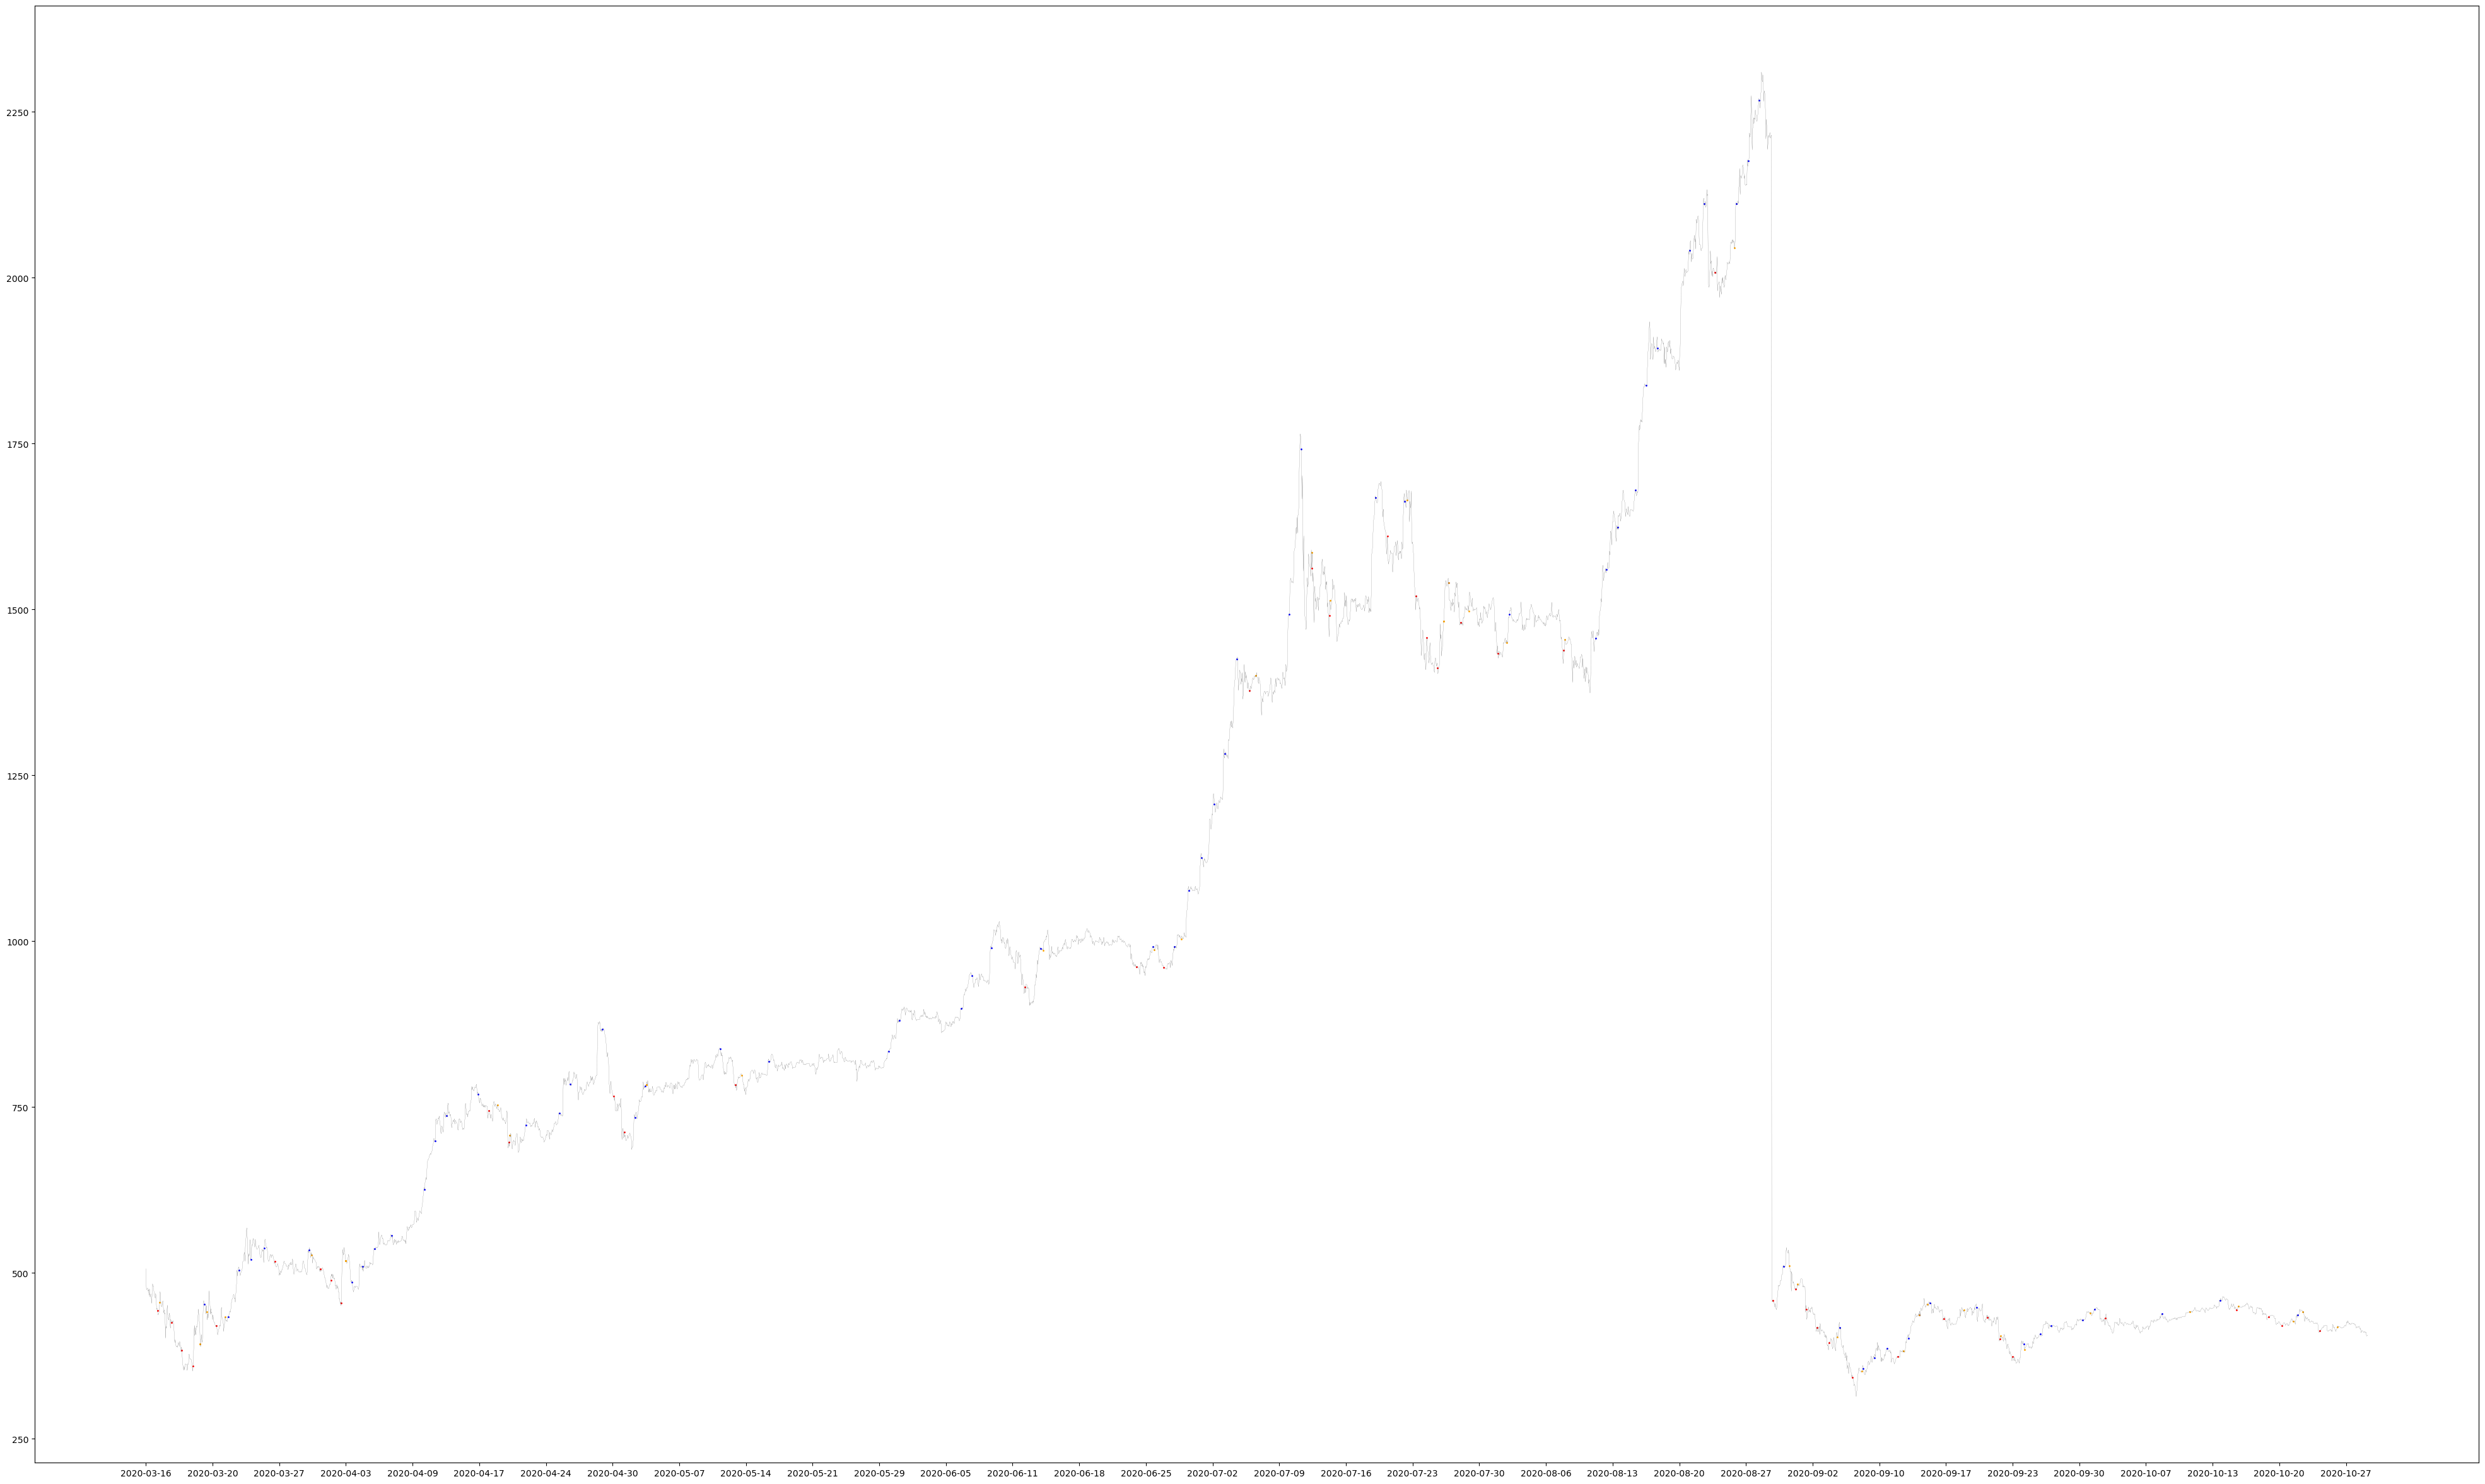

In [10]:
#%matplotlib notebook
%matplotlib inline

from scripts import utils

utils.visualize(ts_time, ts_data, buying_points, selling_points, exit_points)

In [2]:
from scripts import assets

In [3]:
tsla = assets.Equity_Manual_v1('TSLA')

In [5]:
import numpy as np

def get_new_position(asset, test_end_point = 0):
  data_np = np.array(asset.data['o'])

  if test_end_point != 0:
    data_np = data_np[:test_end_point + 1]

  current_price = data_np[-1]

  data_np = data_np[max(-(len(data_np) - asset.start_point), -(1 + asset.settings['duration'])):-1]

  min_price = np.min(data_np)
  max_price = np.max(data_np)

  thr_buy_sig_on = (1 - asset.settings['thr_buy']) * max_price >= current_price
  reb_buy_sig_on = (1 + asset.settings['rebound']) * data_np[-1] <= current_price
  thr_sell_sig_on = (1 + asset.settings['thr_sell']) * min_price <= current_price
  reb_sell_sig_on = (1 - asset.settings['rebound']) * data_np[-1] >= current_price

  if (thr_buy_sig_on and reb_buy_sig_on) or (thr_sell_sig_on and reb_sell_sig_on):
    asset.start_point = len(asset.data['o']) - 2 if test_end_point == 0 else test_end_point

  return thr_buy_sig_on and reb_buy_sig_on, thr_sell_sig_on and reb_sell_sig_on

In [6]:
ts_time = tsla.data['t']
ts_data = tsla.data['o']

buying = []
selling = []

for i in range(1, 24335):
  result = get_new_position(tsla, i)
  if result != (False, False):
    if result[0]:
      buying.append((i, ts_data[i]))
    else:
      selling.append((i, ts_data[i]))

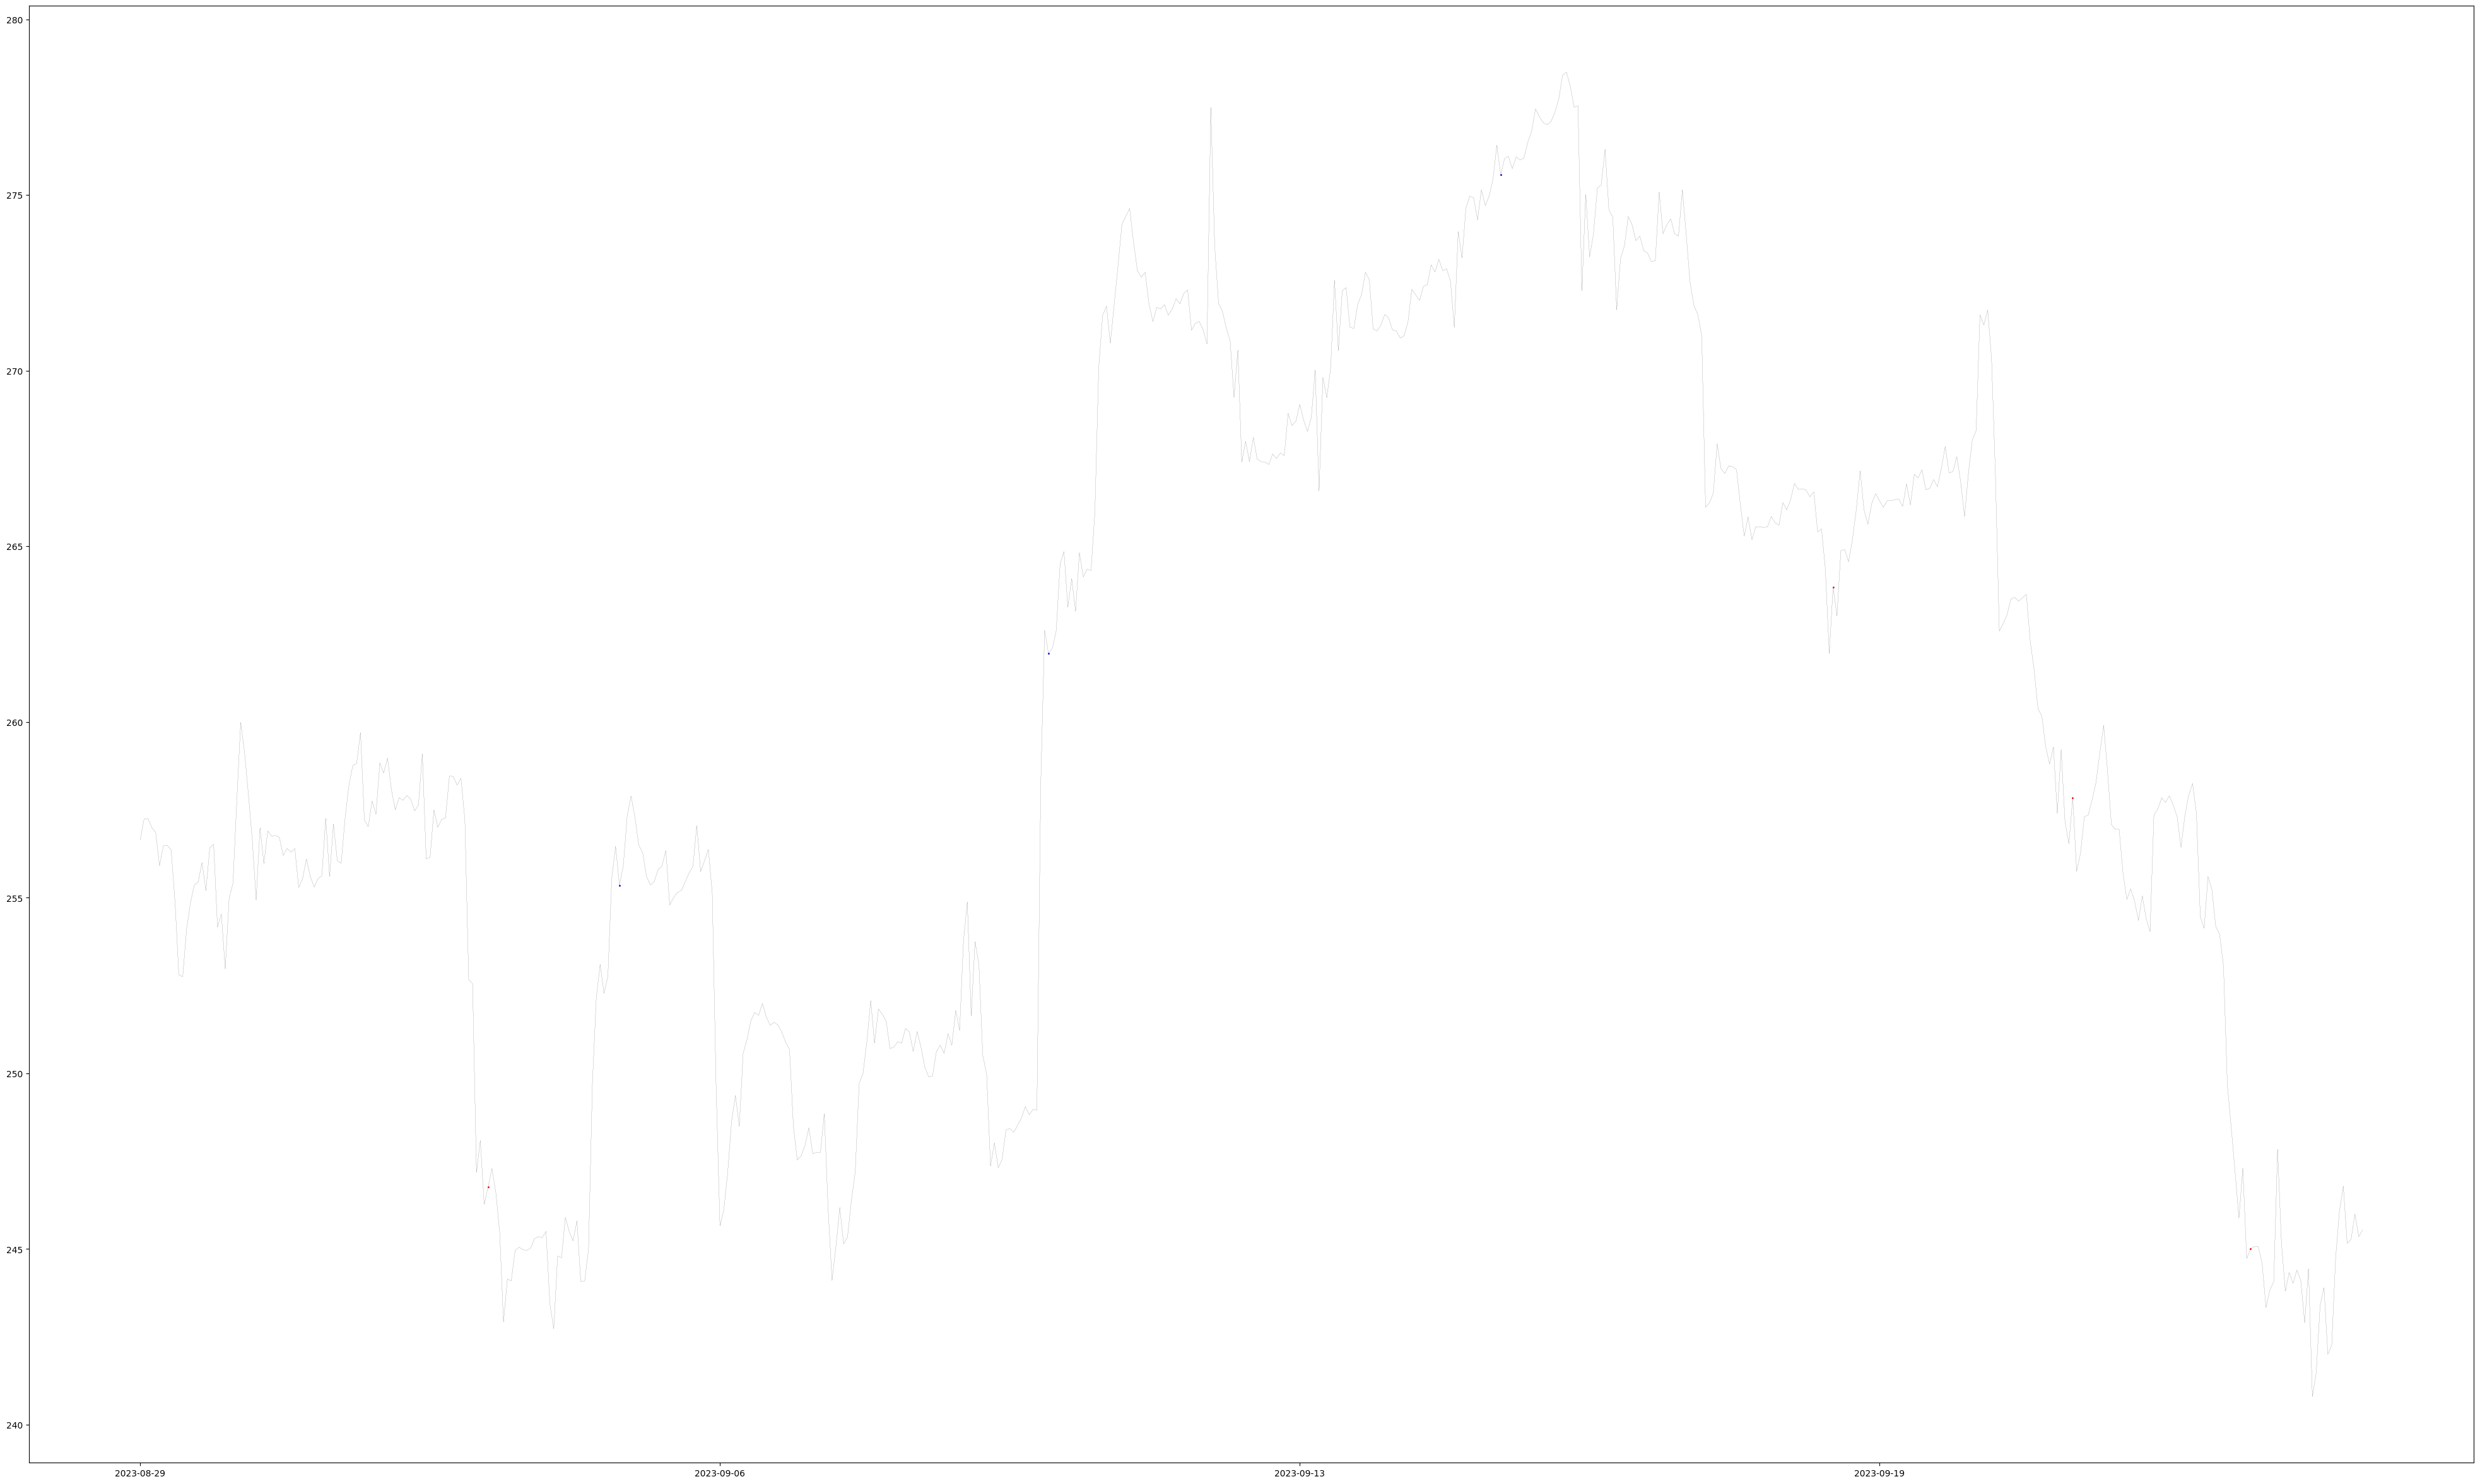

In [7]:
#%matplotlib notebook
%matplotlib inline

from scripts import utils

utils.visualize(ts_time, ts_data, buying, selling, [])

In [8]:
tsla.check_data()

False

In [9]:
get_new_position(tsla, 0)

(False, False)

In [10]:
tsla.data

,t,o
0,2023-08-29T19:30:00Z,256.6400
1,2023-08-29T20:00:00Z,257.2400
2,2023-08-29T20:30:00Z,257.2500
3,2023-08-29T21:00:00Z,257.0000
4,2023-08-29T21:30:00Z,256.8600
...,...,...
571,2023-09-25T17:00:00Z,245.1583
572,2023-09-25T17:30:00Z,245.2700
573,2023-09-25T18:00:00Z,245.9900
574,2023-09-25T18:30:00Z,245.3500


In [16]:
import requests
import os
from dotenv import load_dotenv

load_dotenv(verbose=True)

baseurl = os.getenv('ALPACA_PAPER_BASEURL')

headers = {
  'accept': 'application/json',
  'APCA-API-KEY-ID': os.getenv('ALPACA_PAPER_KEY'),
  'APCA-API-SECRET-KEY': os.getenv('ALPACA_PAPER_KEY_SECRET'),
}

response = requests.get(baseurl + '/account', headers=headers).json()

response['buying_power']

'399482.08'

In [19]:
response = requests.get(baseurl + '/positions', headers=headers).json()

{r['symbol']: r['qty'] for r in response if r['side'] == 'long'}

{'AAPL': '2', 'MSFT': '1'}

In [23]:
headers = {
  'accept': 'application/json',
  'content-type': 'application/json',
  'APCA-API-KEY-ID': os.getenv('ALPACA_PAPER_KEY'),
  'APCA-API-SECRET-KEY': os.getenv('ALPACA_PAPER_KEY_SECRET'),
}

payload = {
  'side': 'sell',
  'type': 'market',
  'time_in_force': 'day',
  'symbol': 'AAPL',
  'qty': 2,
}

response = requests.post(baseurl + '/orders', json=payload, headers=headers).json()

response

{'id': 'cce49ef8-02a5-4e7c-bd95-dabd29557734',
 'client_order_id': '01ff3e4c-92d6-4c66-970f-9a0658040611',
 'created_at': '2023-09-08T01:07:27.712690917Z',
 'updated_at': '2023-09-08T01:07:27.712690917Z',
 'submitted_at': '2023-09-08T01:07:27.712125287Z',
 'filled_at': None,
 'expired_at': None,
 'canceled_at': None,
 'failed_at': None,
 'replaced_at': None,
 'replaced_by': None,
 'replaces': None,
 'asset_id': 'b0b6dd9d-8b9b-48a9-ba46-b9d54906e415',
 'symbol': 'AAPL',
 'asset_class': 'us_equity',
 'notional': None,
 'qty': '2',
 'filled_qty': '0',
 'filled_avg_price': None,
 'order_class': '',
 'order_type': 'market',
 'type': 'market',
 'side': 'sell',
 'time_in_force': 'day',
 'limit_price': None,
 'stop_price': None,
 'status': 'accepted',
 'extended_hours': False,
 'legs': None,
 'trail_percent': None,
 'trail_price': None,
 'hwm': None,
 'subtag': None,
 'source': None}

In [24]:
payload = {
  'side': 'buy',
  'type': 'market',
  'time_in_force': 'day',
  'symbol': 'TSLA',
  'notional': 1000,
}

response = requests.post(baseurl + '/orders', json=payload, headers=headers).json()

response

{'id': 'b6e85ba2-3484-4d0a-a8a9-0e09387bf677',
 'client_order_id': '33638e9c-4703-4738-948b-1a8291c85531',
 'created_at': '2023-09-08T01:09:10.153212846Z',
 'updated_at': '2023-09-08T01:09:10.153212846Z',
 'submitted_at': '2023-09-08T01:09:10.152673796Z',
 'filled_at': None,
 'expired_at': None,
 'canceled_at': None,
 'failed_at': None,
 'replaced_at': None,
 'replaced_by': None,
 'replaces': None,
 'asset_id': '8ccae427-5dd0-45b3-b5fe-7ba5e422c766',
 'symbol': 'TSLA',
 'asset_class': 'us_equity',
 'notional': '1000',
 'qty': None,
 'filled_qty': '0',
 'filled_avg_price': None,
 'order_class': '',
 'order_type': 'market',
 'type': 'market',
 'side': 'buy',
 'time_in_force': 'day',
 'limit_price': None,
 'stop_price': None,
 'status': 'accepted',
 'extended_hours': False,
 'legs': None,
 'trail_percent': None,
 'trail_price': None,
 'hwm': None,
 'subtag': None,
 'source': None}

In [7]:
import requests
import os
from dotenv import load_dotenv

load_dotenv(verbose=True)

dataServerUrl = os.getenv('DATA_SERVER_URL')

headers = {
    'accept': 'application/json',
}

response = requests.post(
    url=dataServerUrl + '/dataArchiving/real_time',
    headers=headers,
    json={
        'symbols': ['TSLA', 'AAPL']
    },
)